In [1]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score, mean_squared_error, root_mean_squared_error
import matplotlib.pylab as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasRegressor

import tensorflow as tf
from keras._tf_keras.keras.models import Model
from keras._tf_keras.keras.layers import Dense, Input, Dropout
from keras._tf_keras.keras.regularizers import l2

np.random.seed(123)
tf.random.set_seed(123)

In [2]:
df0 = pd.read_csv('ETH-USD.csv', index_col=0, parse_dates=True)

In [3]:
df = df0[['Close']].copy()

In [4]:
df['LogClose'] = np.log(df['Close'])

In [5]:
df['DiffLogClose'] = df['LogClose'].diff()

In [6]:
def build_model(units=50, optimizer='adam', activation='relu',dropout_rate=0.2, regularization_rate=0.01):
    i = Input(shape=(Tx,))
    x = Dense(units, activation=activation)(i)  
    x = Dropout(dropout_rate)(x)  
    x = Dense(units, activation=activation, kernel_regularizer=l2(regularization_rate))(x)  
    x = Dense(Ty)(x) 
    model = Model(inputs=i, outputs=x)
    model.compile(loss='mape', optimizer=optimizer)
    return model

In [7]:
param_grid = {
    'model__units': [32, 64],  
    'model__activation': ['relu', 'tanh'],  
    'model__optimizer': ['adam', 'rmsprop'],  
    'model__dropout_rate': [0.1, 0.2], 
    'model__regularization_rate': [0.01, 0.001], 
    'epochs': [50, 100],
}

1 . time going trough
Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
9/9 - 2s - 235ms/step - loss: 758.7996 - val_loss: 170.8952
Epoch 2/100
9/9 - 0s - 16ms/step - loss: 559.6044 - val_loss: 160.8530
Epoch 3/100
9/9 - 0s - 14ms/step - loss: 474.6705 - val_loss: 154.4071
Epoch 4/100
9/9 - 0s - 14ms/step - loss: 456.3949 - val_loss: 150.2098
Epoch 5/100
9/9 - 0s - 14ms/step - loss: 381.8931 - val_loss: 148.4573
Epoch 6/100
9/9 - 0s - 14ms/step - loss: 414.0520 - val_loss: 144.1077
Epoch 7/100
9/9 - 0s - 14ms/step - loss: 381.4534 - val_loss: 141.3983
Epoch 8/100
9/9 - 0s - 14ms/step - loss: 369.4558 - val_loss: 140.1618
Epoch 9/100
9/9 - 0s - 14ms/step - loss: 392.1596 - val_loss: 139.4863
Epoch 10/100
9/9 - 0s - 16ms/step - loss: 407.2112 - val_loss: 138.0241
Epoch 11/100
9/9 - 0s - 14ms/step - loss: 361.3319 - val_loss: 135.6662
Epoch 12/100
9/9 - 0s - 14ms/step - loss: 342.8033 - val_loss: 134.4943
Epoch 13/100
9/9 - 0s - 14ms/step - loss: 321.1342 - val_los

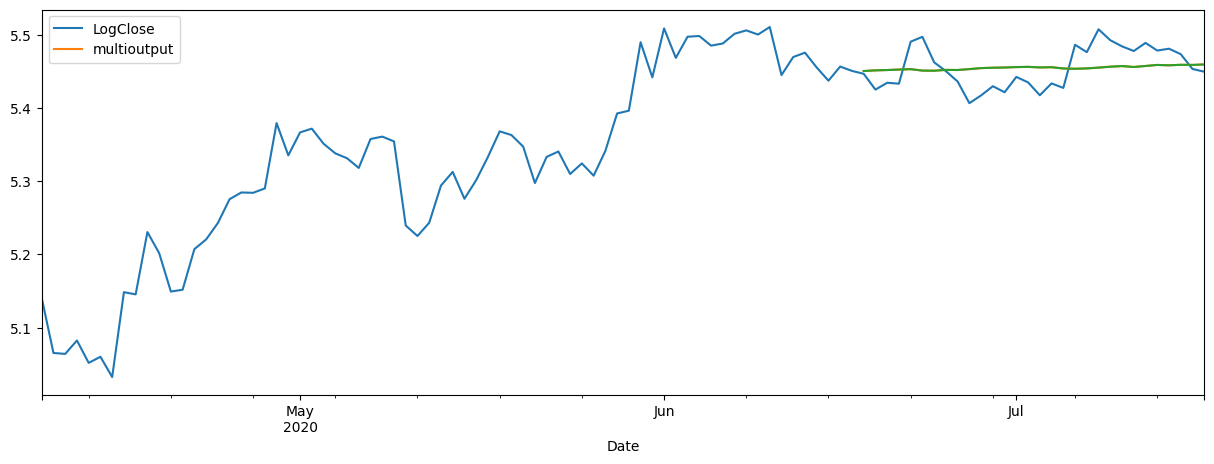

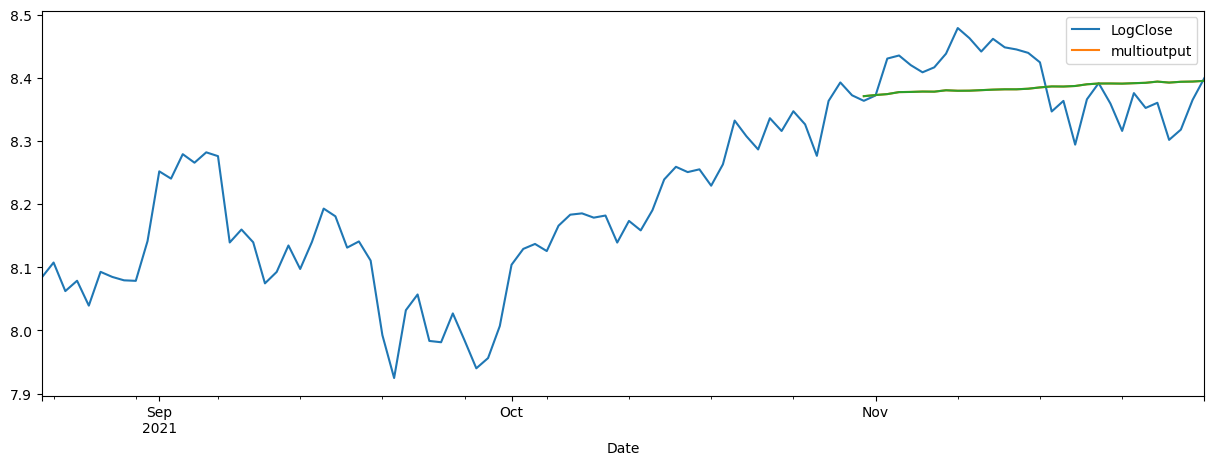

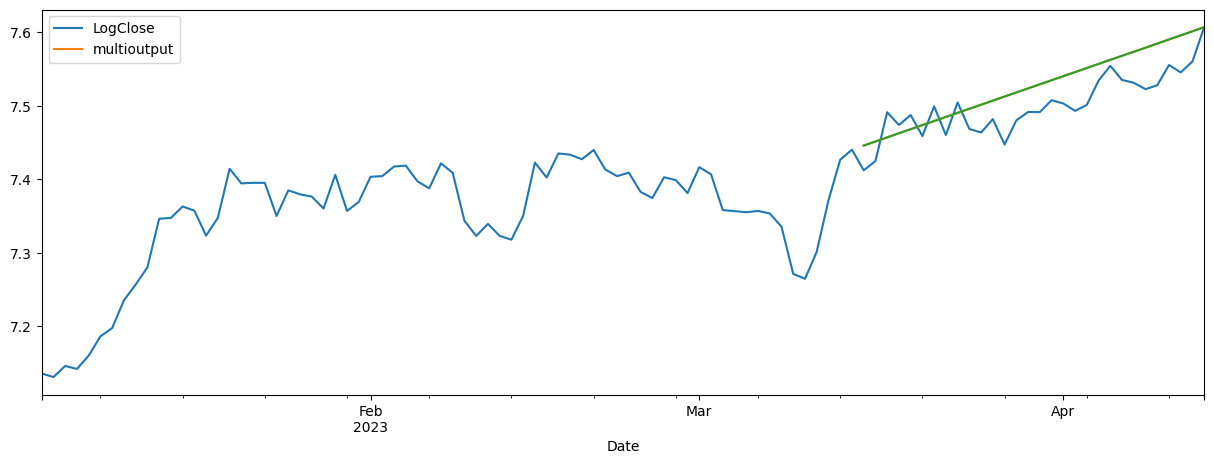

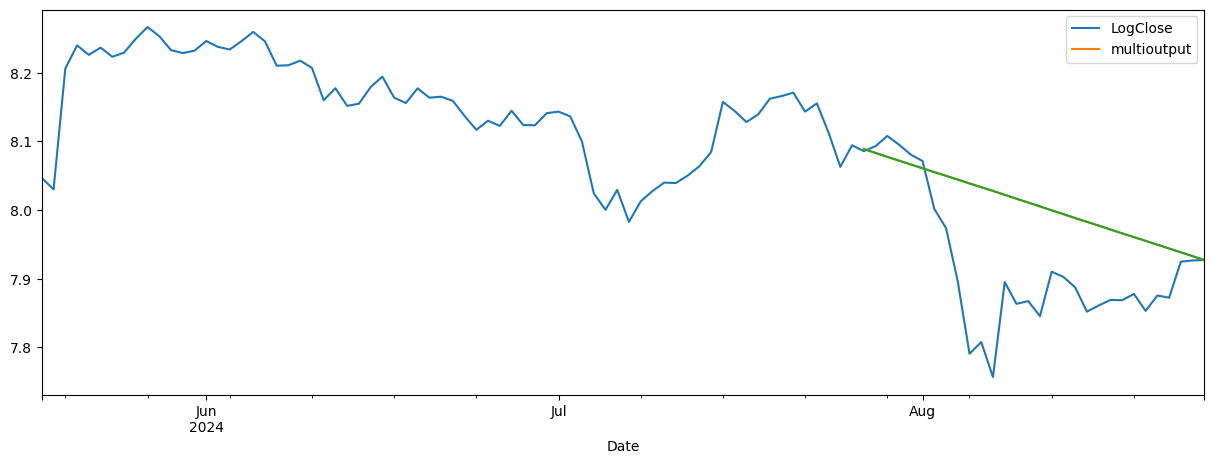

In [8]:
i = 328
real_10d = []
predicted_10d = []
c = 1
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 30
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 10
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    print(c, '. time going trough')
    model = KerasRegressor(model=build_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptrain = best_model.predict(Xtrain_m)
    Ptest = best_model.predict(Xtest_m)
    
    Ptrain = Ptrain[:,0]
    Ptest = Ptest[0]
    
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose', 'multioutput']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multioutput'])
    
    predicted_10d.append(predicted_temp)
    real_10d.append(real_temp)
    c = c + 1

1 . time going trough
Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
7/7 - 2s - 221ms/step - loss: 1373.8793 - val_loss: 253.0067
Epoch 2/100
7/7 - 0s - 18ms/step - loss: 1034.4119 - val_loss: 245.8321
Epoch 3/100
7/7 - 0s - 20ms/step - loss: 922.7459 - val_loss: 237.9764
Epoch 4/100
7/7 - 0s - 16ms/step - loss: 830.2170 - val_loss: 235.6447
Epoch 5/100
7/7 - 0s - 18ms/step - loss: 815.3876 - val_loss: 232.2969
Epoch 6/100
7/7 - 0s - 16ms/step - loss: 769.3828 - val_loss: 226.6979
Epoch 7/100
7/7 - 0s - 16ms/step - loss: 648.4706 - val_loss: 221.2422
Epoch 8/100
7/7 - 0s - 18ms/step - loss: 670.9230 - val_loss: 216.5745
Epoch 9/100
7/7 - 0s - 15ms/step - loss: 723.5793 - val_loss: 212.5784
Epoch 10/100
7/7 - 0s - 16ms/step - loss: 662.2993 - val_loss: 209.9120
Epoch 11/100
7/7 - 0s - 15ms/step - loss: 656.1234 - val_loss: 203.6108
Epoch 12/100
7/7 - 0s - 18ms/step - loss: 709.2322 - val_loss: 201.5409
Epoch 13/100
7/7 - 0s - 17ms/step - loss: 590.7536 - val_l

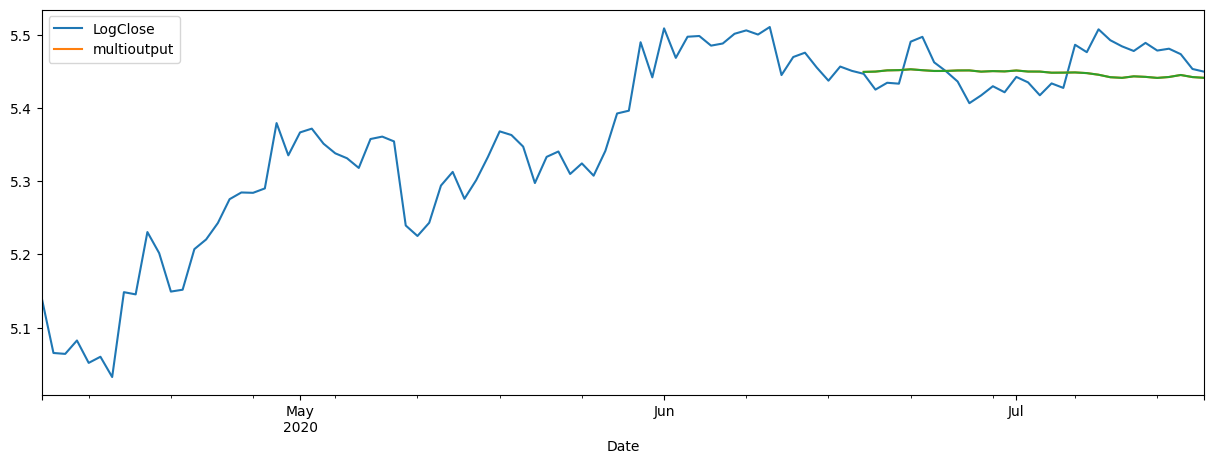

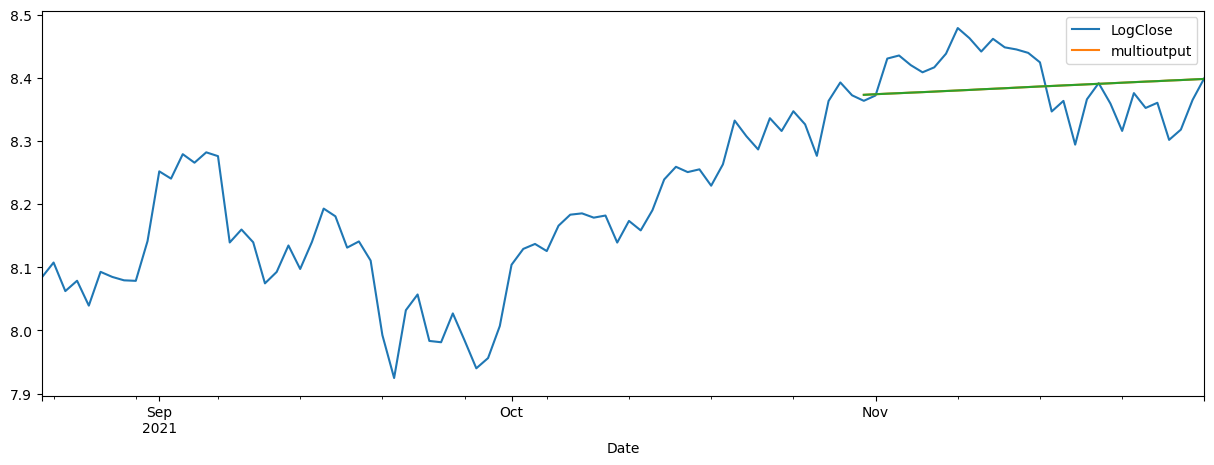

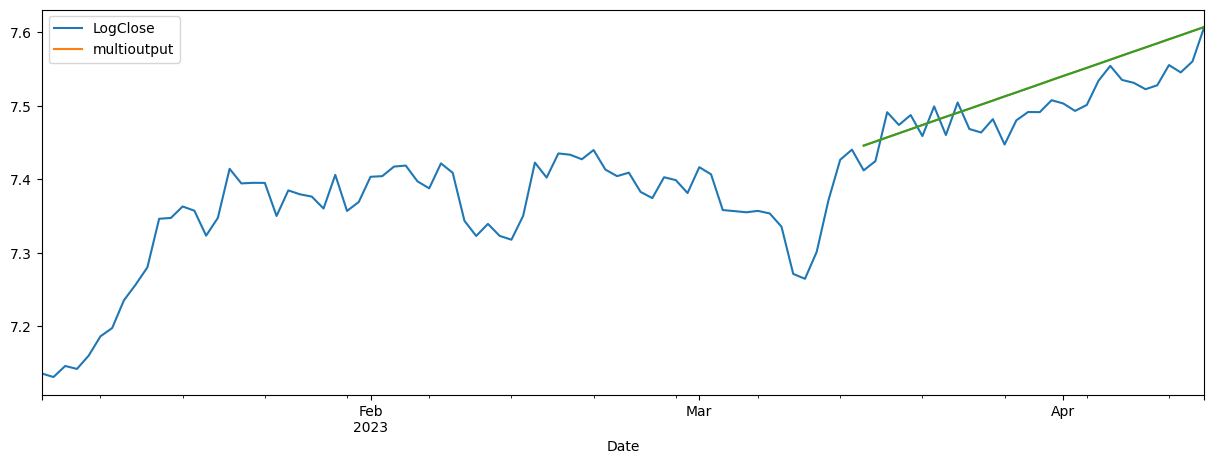

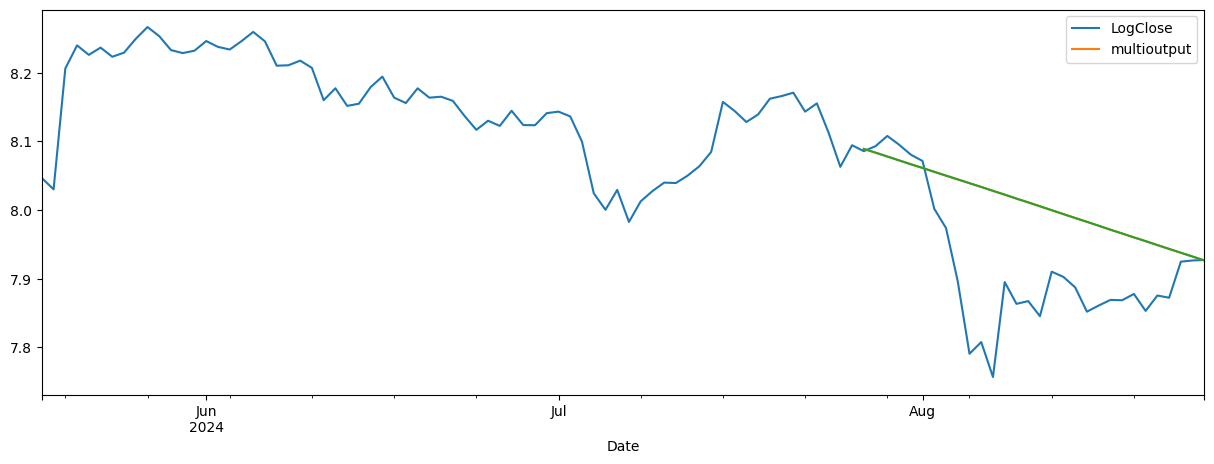

In [9]:
i = 328
real_50d = []
predicted_50d = []
c = 1
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 30
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 50
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    print(c, '. time going trough')
    model = KerasRegressor(model=build_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptrain = best_model.predict(Xtrain_m)
    Ptest = best_model.predict(Xtest_m)
    
    Ptrain = Ptrain[:,0]
    Ptest = Ptest[0]
    
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose', 'multioutput']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multioutput'])
    
    predicted_50d.append(predicted_temp)
    real_50d.append(real_temp)
    c = c + 1

1 . time going trough
Fitting 2 folds for each of 64 candidates, totalling 128 fits
Epoch 1/100
6/6 - 2s - 264ms/step - loss: 1549.1963 - val_loss: 528.5000
Epoch 2/100
6/6 - 0s - 18ms/step - loss: 1213.5054 - val_loss: 498.1243
Epoch 3/100
6/6 - 0s - 18ms/step - loss: 884.6685 - val_loss: 482.0544
Epoch 4/100
6/6 - 0s - 20ms/step - loss: 878.7227 - val_loss: 473.6743
Epoch 5/100
6/6 - 0s - 21ms/step - loss: 765.9250 - val_loss: 467.1222
Epoch 6/100
6/6 - 0s - 21ms/step - loss: 715.6558 - val_loss: 465.4114
Epoch 7/100
6/6 - 0s - 18ms/step - loss: 761.8003 - val_loss: 459.9464
Epoch 8/100
6/6 - 0s - 19ms/step - loss: 641.2028 - val_loss: 446.1642
Epoch 9/100
6/6 - 0s - 18ms/step - loss: 740.5969 - val_loss: 442.2573
Epoch 10/100
6/6 - 0s - 18ms/step - loss: 667.2793 - val_loss: 436.9763
Epoch 11/100
6/6 - 0s - 21ms/step - loss: 627.4319 - val_loss: 427.4537
Epoch 12/100
6/6 - 0s - 18ms/step - loss: 676.0914 - val_loss: 421.6871
Epoch 13/100
6/6 - 0s - 20ms/step - loss: 599.8409 - val_l

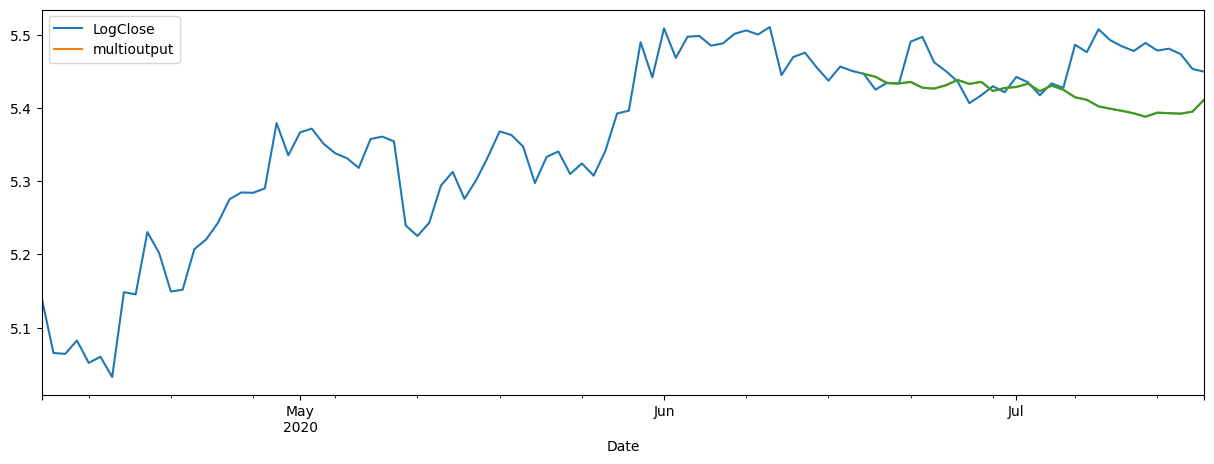

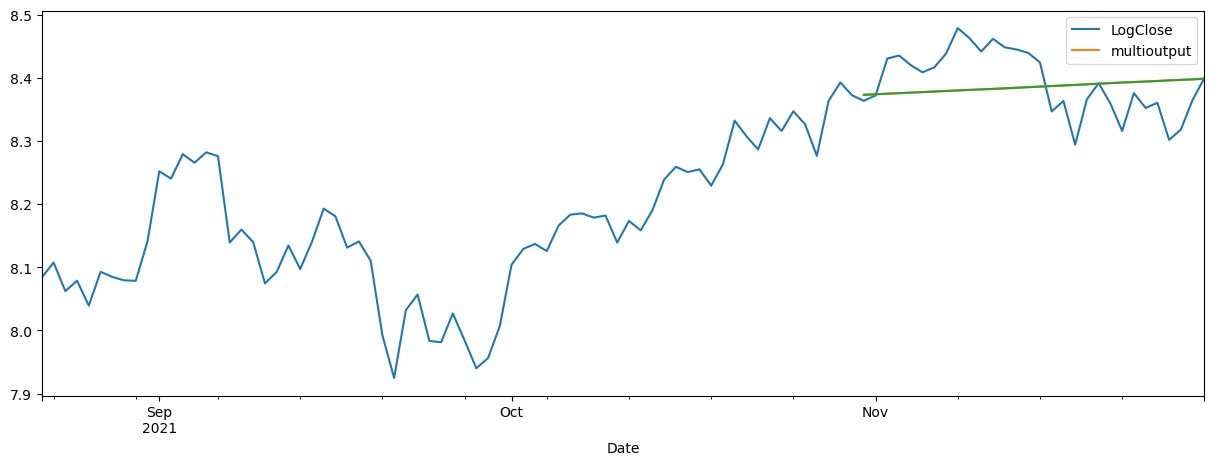

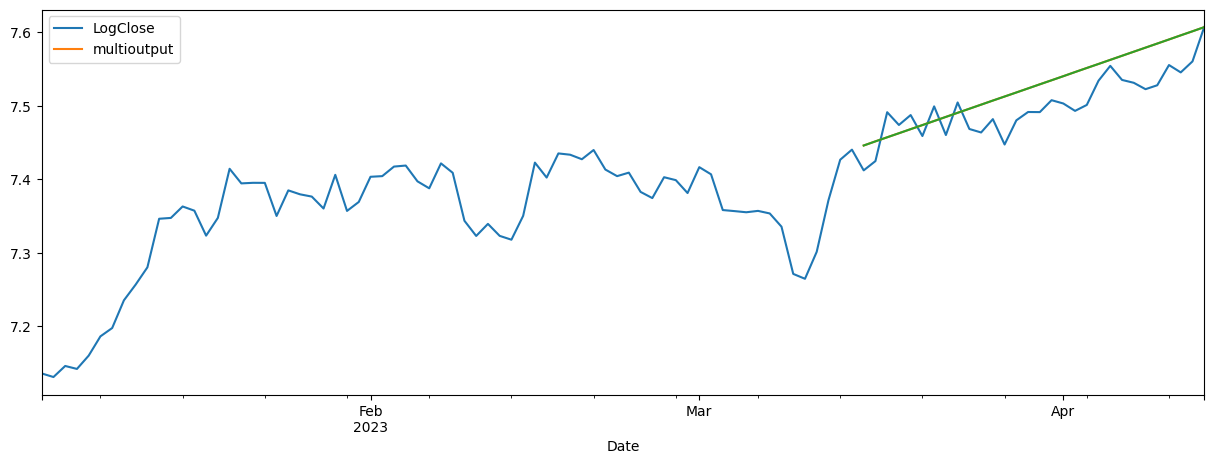

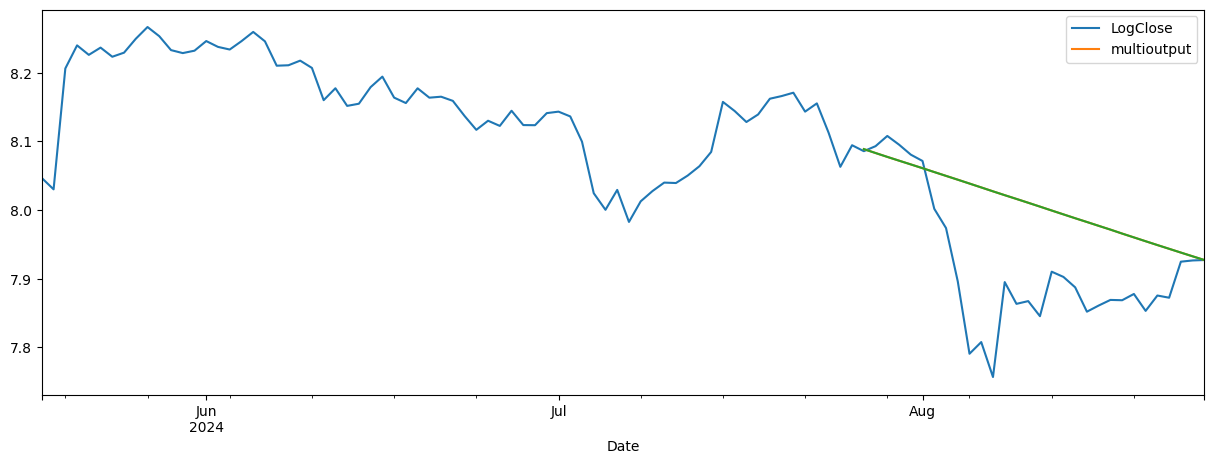

In [10]:
i = 328
real_100d = []
predicted_100d = []
c = 1
while i <= len(df):
    temp = df[:i].copy()
    
    i = i + 500
    
    Ntest = 30
    train = temp.iloc[:-Ntest]
    test = temp.iloc[-Ntest:]
    
    scaler = StandardScaler()
    train_scaled = scaler.fit_transform(train[['DiffLogClose']])
    test_scaled = scaler.fit_transform(test[['DiffLogClose']])
    
    train_idx = temp.index <= train.index[-1]
    test_idx = temp.index > train.index[-1]
    
    temp.loc[train_idx, 'ScaledLogReturn'] = train_scaled.flatten()
    temp.loc[test_idx, 'ScaledLogReturn'] = test_scaled.flatten()
    
    series = temp['ScaledLogReturn'].dropna().to_numpy()

    Tx = 100
    Ty = Ntest
    X = []
    Y = []
    for t in range(len(series) - Tx - Ty + 1):
      x = series[t:t+Tx]
      X.append(x)
      y = series[t+Tx:t+Tx+Ty]
      Y.append(y)
    
    X = np.array(X).reshape(-1, Tx)
    Y = np.array(Y).reshape(-1, Ty)
    
    Xtrain_m, Ytrain_m = X[:-Ntest], Y[:-Ntest]
    Xtest_m, Ytest_m = X[-Ntest:], Y[-Ntest:]
    print(c, '. time going trough')
    model = KerasRegressor(model=build_model, verbose=2)
    grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=2, verbose=2)
    grid_result = grid.fit(Xtrain_m, Ytrain_m,validation_data=(Xtest_m, Ytest_m))
    best_model = grid_result.best_estimator_
    
    Ptrain = best_model.predict(Xtrain_m)
    Ptest = best_model.predict(Xtest_m)
    
    Ptrain = Ptrain[:,0]
    Ptest = Ptest[0]
    
    Ptest = scaler.inverse_transform(Ptest.reshape(-1, 1)).flatten()
    
    last_train = train.iloc[-1]['LogClose']
    
    temp.loc[test_idx, 'multioutput'] = last_train + np.cumsum(Ptest)
    
    predicted_temp = np.array(np.exp(temp.loc[test_idx,'multioutput']))
    real_temp = np.array(temp.loc[test_idx,'Close'])
    
    temp.iloc[-100:][['LogClose', 'multioutput']].plot(figsize=(15, 5));
    plt.plot(temp.loc[test_idx, 'multioutput'])
    
    predicted_100d.append(predicted_temp)
    real_100d.append(real_temp)
    
    c = c + 1

In [11]:
print("R2 score for 10, 50 and 100 days are:",round(r2_score(real_10d, predicted_10d),4), round(r2_score(real_50d, predicted_50d),4),round(r2_score(real_100d, predicted_100d),4))

R2 score for 10, 50 and 100 days are: 0.9824 0.9823 0.9823


In [12]:
print("MAPE score for 10, 50 and 100 days are:",round(mean_absolute_percentage_error(real_10d, predicted_10d)*100,2),round(mean_absolute_percentage_error(real_50d, predicted_50d)*100,2),round(mean_absolute_percentage_error(real_100d, predicted_100d)*100,2))

MAPE score for 10, 50 and 100 days are: 5.11 5.19 5.51


In [13]:
print("MAE scores for 10, 50 and 100 days are:",round(mean_absolute_error(real_10d, predicted_10d),2),round(mean_absolute_error(real_50d, predicted_50d),2),round(mean_absolute_error(real_100d, predicted_100d),2))

MAE scores for 10, 50 and 100 days are: 133.28 133.87 134.56


In [14]:
print("MSE scores for 10, 50 and 100 days are:",round(mean_squared_error(real_10d, predicted_10d),2),round(mean_squared_error(real_50d, predicted_50d),2),round(mean_squared_error(real_100d, predicted_100d),2))

MSE scores for 10, 50 and 100 days are: 41950.21 42132.85 42049.06


In [15]:
print("RMSE scores for 10, 50 and 100 days are:",round(root_mean_squared_error(real_10d, predicted_10d),2),round(root_mean_squared_error(real_50d, predicted_50d),2),round(root_mean_squared_error(real_100d, predicted_100d),2))

RMSE scores for 10, 50 and 100 days are: 180.3 181.01 181.0
